**Competition Goal:** Predict which passengers were transported to an alternate dimension during the Spaceship Titanic's collision with a spacetime anomaly.

**What You Will Learn in This Notebook:**
1. How to explore and understand a dataset before building any model
2. How to clean messy data (handle missing values, encode categories, scale numbers)
3. How to train five different machine learning models and compare them fairly
4. How to pick the best model and generate a Kaggle submission file

**Why This Order Matters:**
Think of machine learning like cooking. You cannot just throw raw ingredients into an oven and hope for the best. You need to wash them, chop them, measure them, and then cook them properly. Each step in this notebook exists for a reason, and skipping any step can ruin the final result. We will explain every step as we go.

---

## Section 1 - Import Libraries

Before writing any analysis code, we load the tools (libraries) we will need.

| Library | Purpose |
|---------|---------|
| pandas | Reading CSVs, manipulating tables of data |
| numpy | Fast math operations on arrays |
| matplotlib / seaborn | Drawing charts and visualizations |
| scikit-learn | Machine learning models, preprocessing, evaluation |
| xgboost | Gradient boosted tree model (often the top performer on tabular data) |

**What happens if you skip this?** Nothing else in the notebook will work. This is like plugging in your appliances before you can use them.

In [58]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

import time

# Make charts look clean
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("All libraries loaded successfully.")

All libraries loaded successfully.


## Section 2 - Load the Data

We have three files from Kaggle:

| File | Rows | Purpose |
|------|------|---------|
| train.csv | ~8700 | Has the answer (Transported column). We learn from this. |
| test.csv | ~4300 | No answer column. We predict on this and submit to Kaggle. |
| sample_submission.csv | ~4300 | Shows the exact format Kaggle expects. |

**Why load all three now?** We need to understand the full picture. The test set may have categories or patterns the training set does not, and vice versa.

In [59]:
# Load the datasets
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test  = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
sample_submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

print(f"Training set   : {train.shape[0]} rows, {train.shape[1]} columns")
print(f"Test set       : {test.shape[0]} rows, {test.shape[1]} columns")
print(f"Submission file: {sample_submission.shape[0]} rows, {sample_submission.shape[1]} columns")

Training set   : 8693 rows, 14 columns
Test set       : 4277 rows, 13 columns
Submission file: 4277 rows, 2 columns


## Section 3 - First Look at the Data

Before doing anything fancy, we simply look at the data. This is like a doctor checking your vitals before running tests. We want to know:
- What columns exist and what type each one is (number vs text)
- How many values are missing
- What the first few rows look like

**What happens if you skip this?** You might build a model on data you do not understand. You could accidentally treat a text column as a number, or miss a column that is 90 percent empty.

In [60]:
print("=== First 5 rows of training data ===")
train.head()

=== First 5 rows of training data ===


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [61]:
print("=== Data types and non-null counts ===")
train.info()

=== Data types and non-null counts ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [62]:
print("=== Basic statistics for numeric columns ===")
train.describe()

=== Basic statistics for numeric columns ===


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [63]:
print("=== Basic statistics for categorical (text) columns ===")
train.describe(include='object')

=== Basic statistics for categorical (text) columns ===


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,9280_02,Earth,False,G/734/S,TRAPPIST-1e,False,Ankalik Nateansive
freq,1,4602,5439,8,5915,8291,2


## Section 4 - Understand Missing Values

Real-world data is almost never complete. Passengers may not have filled in every field, or the damaged computer system lost some records. We need to know exactly how much is missing and where.

**Why this matters:** Most machine learning algorithms cannot handle empty cells. If we feed them missing data, they will either crash or silently produce garbage predictions.

In [64]:
missing_train = train.isnull().sum()
missing_pct = (missing_train/len(train) *100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing_train,
    'Missing Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

              Missing Count  Missing Percentage
HomePlanet              201                2.31
CryoSleep               217                2.50
Cabin                   199                2.29
Destination             182                2.09
Age                     179                2.06
VIP                     203                2.34
RoomService             181                2.08
FoodCourt               183                2.11
ShoppingMall            208                2.39
Spa                     183                2.11
VRDeck                  188                2.16
Name                    200                2.30


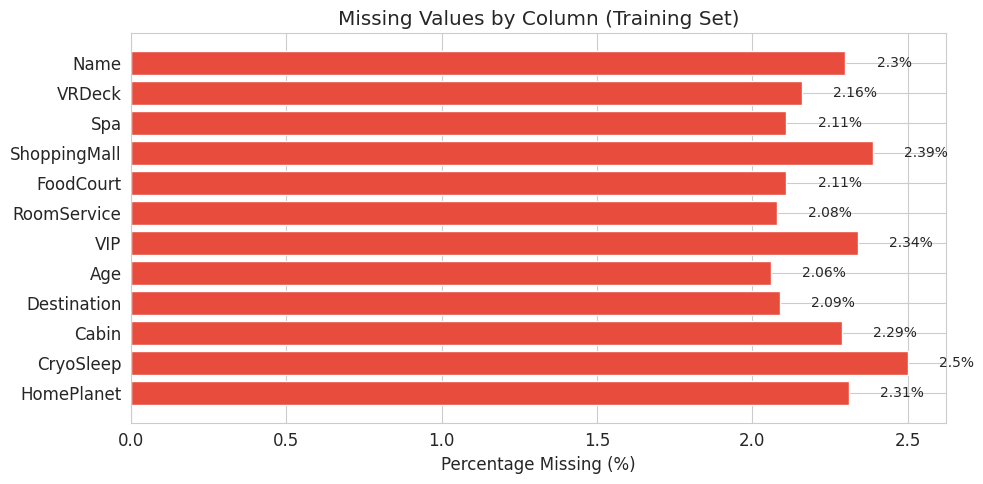

In [65]:
# Visualize missing values
fig, ax = plt.subplots(figsize=(10, 5))
cols_with_missing = missing_df[missing_df['Missing Count'] > 0].index
colors = ['#e74c3c' if pct > 2 else '#f39c12' for pct in missing_df.loc[cols_with_missing, 'Missing Percentage']]
bars = ax.barh(cols_with_missing, missing_df.loc[cols_with_missing, 'Missing Percentage'], color=colors)
ax.set_xlabel('Percentage Missing (%)')
ax.set_title('Missing Values by Column (Training Set)')
for bar, val in zip(bars, missing_df.loc[cols_with_missing, 'Missing Percentage']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
            f'{val}%', va='center', fontsize=10)
plt.tight_layout()
plt.savefig('chart_01_missing_values.png', dpi=150, bbox_inches='tight')
plt.show()

In [66]:
print("INSIGHT: Most columns have roughly 2% missing data. This is manageable.")
print("The Cabin column is especially important because we can extract deck and side from it.")

INSIGHT: Most columns have roughly 2% missing data. This is manageable.
The Cabin column is especially important because we can extract deck and side from it.


## Section 5 - Explore the Target Variable

The target variable is `Transported` - the thing we are trying to predict. It is a binary column: True (the passenger was transported) or False (they were not).

**Why check this first?** If the target is heavily imbalanced (e.g., 95% False and 5% True), we would need special techniques. A model could just predict "False" every time and get 95% accuracy while being completely useless.

Transported
True     4378
False    4315
Name: count, dtype: int64


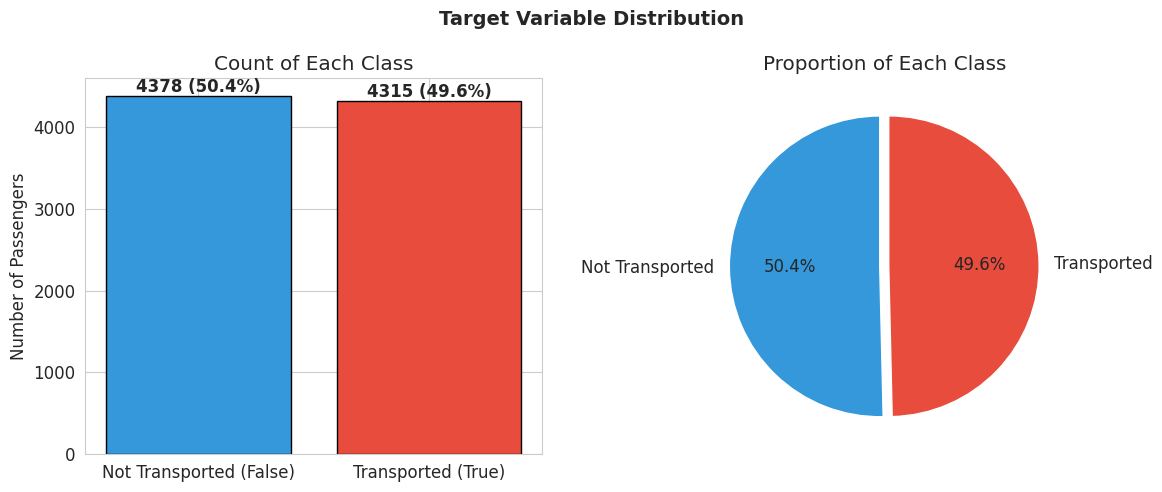

In [67]:
# Check the balance of the target
target_counts = train['Transported'].value_counts()
target_pct = train['Transported'].value_counts(normalize=True) * 100

print(target_counts)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
colors = ['#3498db', '#e74c3c']
axes[0].bar(['Not Transported (False)', 'Transported (True)'],
            target_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Count of Each Class')
axes[0].set_ylabel('Number of Passengers')
for i, (count, pct) in enumerate(zip(target_counts.values, target_pct.values)):
    axes[0].text(i, count + 50, f'{count} ({pct:.1f}%)', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(target_counts.values, labels=['Not Transported', 'Transported'],
            autopct='%1.1f%%', colors=colors, startangle=90, explode=(0.03, 0.03))
axes[1].set_title('Proportion of Each Class')

plt.suptitle('Target Variable Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_02_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [68]:
print("INSIGHT: The classes are almost perfectly balanced (~50/50).")
print("This is great news - we do not need to worry about class imbalance techniques.")

INSIGHT: The classes are almost perfectly balanced (~50/50).
This is great news - we do not need to worry about class imbalance techniques.


## Section 6 - Explore Categorical Features

Categorical features are columns with text values (like planet names or True/False). Let us see what unique values each one has and how they relate to the target.

**Why this matters:** Some categories might be strongly linked to being transported. For example, maybe passengers from a specific planet are more likely to be transported. These patterns are gold for our models.

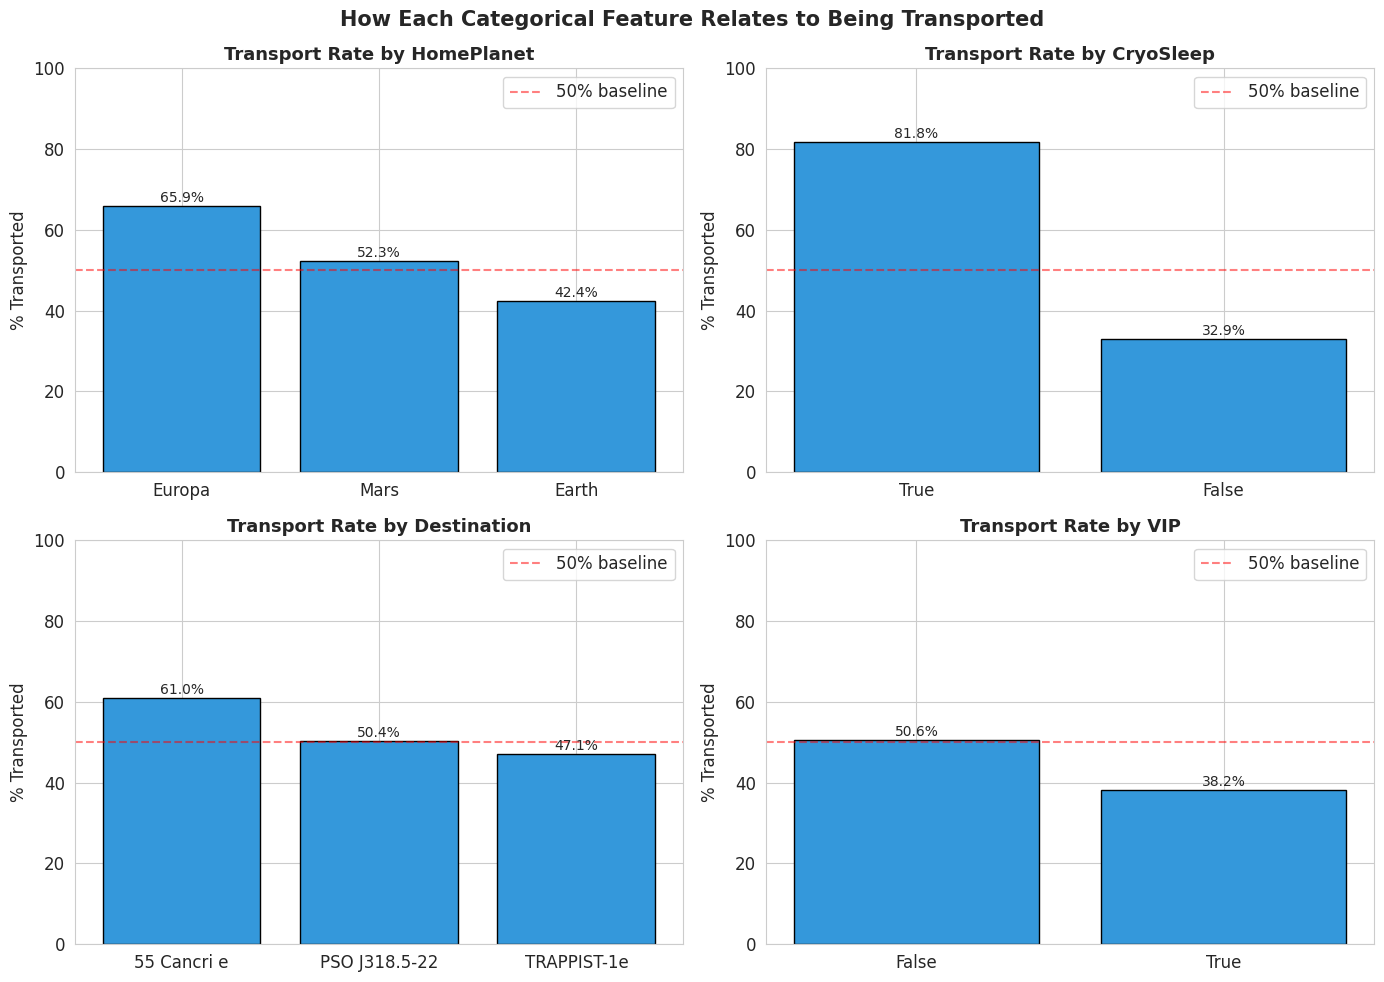

In [69]:
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Calculate transport rate for each category
    ct = train.groupby(col)['Transported'].mean().sort_values(ascending=False)
    bars = axes[i].bar(ct.index.astype(str), ct.values * 100, color='#3498db', edgecolor='black')
    axes[i].set_title(f'Transport Rate by {col}', fontsize=13, fontweight='bold')
    axes[i].set_ylabel('% Transported')
    axes[i].set_ylim(0, 100)
    axes[i].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% baseline')
    axes[i].legend()
    for bar, val in zip(bars, ct.values * 100):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                     f'{val:.1f}%', ha='center', fontsize=10)

plt.suptitle('How Each Categorical Feature Relates to Being Transported',
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_03_categorical_vs_target.png', dpi=150, bbox_inches='tight')
plt.show()

In [70]:
print("KEY INSIGHTS:")
print("- CryoSleep is the STRONGEST predictor: ~81% of cryosleep passengers were transported.")
print("- HomePlanet matters: Europa passengers are transported more often than Earth passengers.")
print("- VIP passengers are LESS likely to be transported.")
print("- Destination has a moderate effect: 55 Cancri e passengers are transported more often.")

KEY INSIGHTS:
- CryoSleep is the STRONGEST predictor: ~81% of cryosleep passengers were transported.
- HomePlanet matters: Europa passengers are transported more often than Earth passengers.
- VIP passengers are LESS likely to be transported.
- Destination has a moderate effect: 55 Cancri e passengers are transported more often.


## Section 7 - Explore Numeric Features

Numeric features are columns with numbers (like Age, RoomService spending, etc.). We want to understand their distributions and how they relate to the target.

**Why this matters:** If spending patterns differ between transported and non-transported passengers, our models can use that information. Also, if a numeric column has extreme outliers, it might confuse certain algorithms.

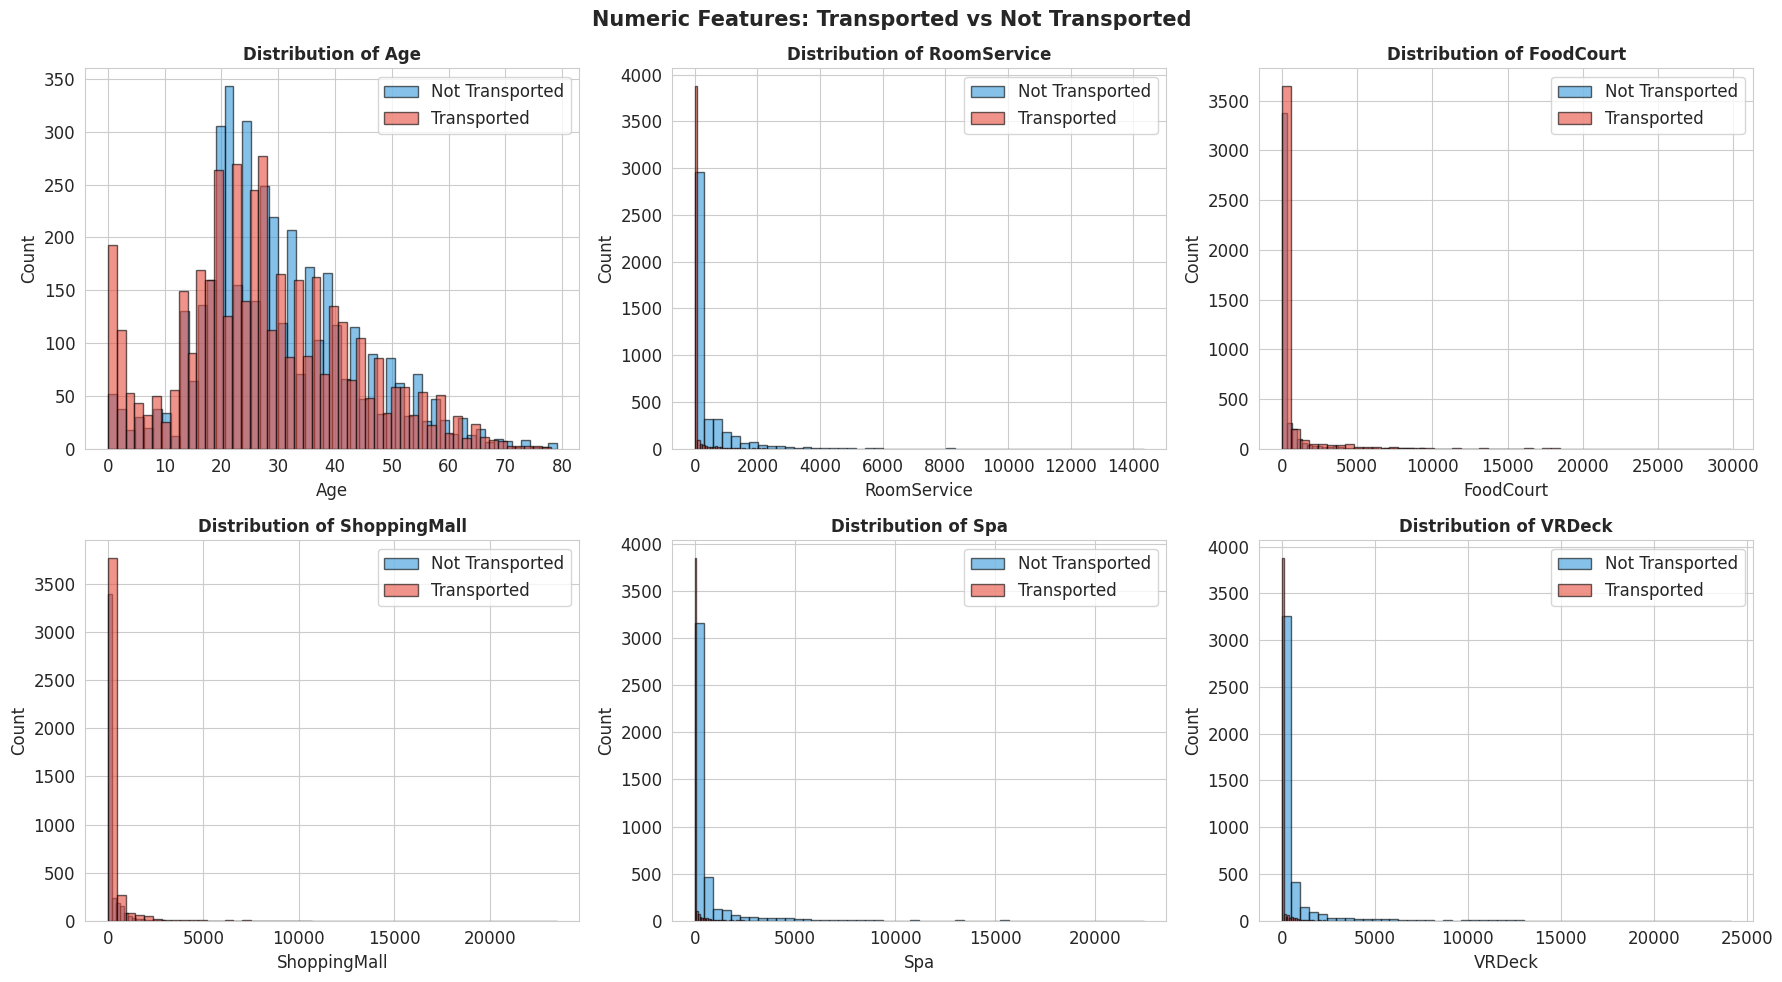

In [71]:
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    # Separate by target
    transported = train[train['Transported'] == True][col].dropna()
    not_transported = train[train['Transported'] == False][col].dropna()

    axes[i].hist(not_transported, bins=50, alpha=0.6, label='Not Transported',
                 color='#3498db', edgecolor='black')
    axes[i].hist(transported, bins=50, alpha=0.6, label='Transported',
                 color='#e74c3c', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend()

plt.suptitle('Numeric Features: Transported vs Not Transported', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_04_numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [72]:
print("KEY INSIGHTS:")
print("- Spending columns (RoomService, FoodCourt, etc.) are heavily right-skewed.")
print("  Most passengers spent 0, but a few spent thousands.")
print("- Transported passengers tend to have LOWER spending across all amenities.")
print("  This makes sense: cryosleep passengers cannot spend, and they are transported more.")
print("- Age shows a slight pattern: younger passengers seem slightly more likely to be transported.")

KEY INSIGHTS:
- Spending columns (RoomService, FoodCourt, etc.) are heavily right-skewed.
  Most passengers spent 0, but a few spent thousands.
- Transported passengers tend to have LOWER spending across all amenities.
  This makes sense: cryosleep passengers cannot spend, and they are transported more.
- Age shows a slight pattern: younger passengers seem slightly more likely to be transported.


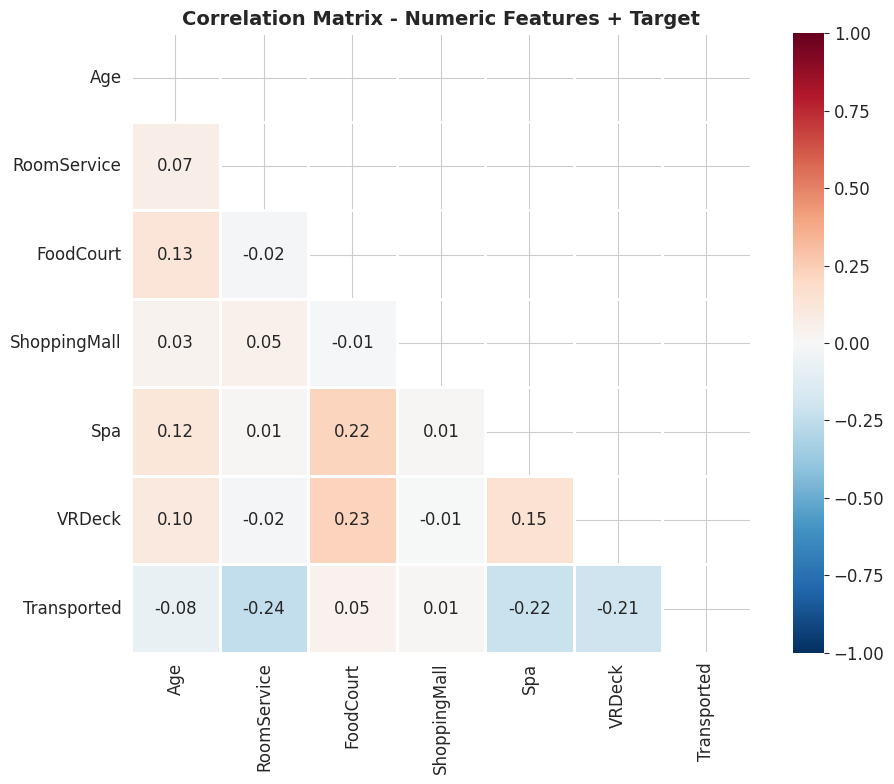

In [73]:
# Correlation heatmap of numeric features with the target
numeric_for_corr = train[numeric_cols + ['Transported']].copy()
numeric_for_corr['Transported'] = numeric_for_corr['Transported'].astype(int)
corr_matrix = numeric_for_corr.corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=1, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Correlation Matrix - Numeric Features + Target', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_05_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [74]:
print("KEY INSIGHTS:")
print("- Spa and VRDeck have the strongest NEGATIVE correlation with Transported.")
print("  Meaning: the more you spend on Spa/VRDeck, the LESS likely you are transported.")
print("- RoomService also negatively correlates with Transported.")
print("- No two features are extremely correlated with each other (no multicollinearity problem).")

KEY INSIGHTS:
- Spa and VRDeck have the strongest NEGATIVE correlation with Transported.
  Meaning: the more you spend on Spa/VRDeck, the LESS likely you are transported.
- RoomService also negatively correlates with Transported.
- No two features are extremely correlated with each other (no multicollinearity problem).


## Section 8 - Feature Engineering

Feature engineering means creating NEW columns from existing ones that might help our models make better predictions. This is often the single most impactful step in a machine learning project.

We will extract information from:
1. **Cabin** - split into Deck, Cabin Number, and Side (Port/Starboard)
2. **PassengerId** - extract the Group number (people traveling together)
3. **Spending columns** - create a Total Spending feature and a "spent anything?" flag

**Why this matters:** Raw data often hides useful patterns inside text fields. By extracting Deck from the Cabin column, we give the model a powerful new signal. Skipping this step means leaving free performance on the table.

In [75]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [76]:
def engineer_features(df):
    """
    Apply all feature engineering steps to a dataframe.
    We apply the SAME transformations to both train and test to keep them consistent.
    """
    df = df.copy()

    # --- 1. Extract from Cabin: deck/num/side ---
    df['Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0] if pd.notna(x) else np.nan)
    df['CabinNum'] = df['Cabin'].apply(lambda x: int(x.split('/')[1]) if pd.notna(x) else np.nan)
    df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[2] if pd.notna(x) else np.nan)

    # --- 2. Extract group from PassengerId ---
    df['Group'] = df['PassengerId'].apply(lambda x: int(x.split('_')[0]))
    df['GroupSize'] = df.groupby('Group')['Group'].transform('count')

    # --- 3. Total spending and binary spending flag ---
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpending'] = df[spending_cols].sum(axis=1)
    df['HasSpent'] = (df['TotalSpending'] > 0).astype(int)

    # --- 4. Age groups (binning) ---
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 30, 50, 100],
                            labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'],
                            right=True)

    return df

train = engineer_features(train)
test  = engineer_features(test)

print("New features created:")
print(f"  Columns before: PassengerId, HomePlanet, CryoSleep, Cabin, ...")
print(f"  Columns after : {train.shape[1]} total columns")
print()
print("Sample of new features:")
train[['PassengerId', 'Cabin', 'Deck', 'CabinNum', 'Side',
       'Group', 'GroupSize', 'TotalSpending', 'HasSpent', 'AgeGroup']].head(8)

New features created:
  Columns before: PassengerId, HomePlanet, CryoSleep, Cabin, ...
  Columns after : 22 total columns

Sample of new features:


,PassengerId,Cabin,Deck,CabinNum,Side,Group,GroupSize,TotalSpending,HasSpent,AgeGroup
0,0001_01,B/0/P,B,0.0,P,1,1,0.0,0,Adult
1,0002_01,F/0/S,F,0.0,S,2,1,736.0,1,YoungAdult
2,0003_01,A/0/S,A,0.0,S,3,2,10383.0,1,Senior
3,0003_02,A/0/S,A,0.0,S,3,2,5176.0,1,Adult
4,0004_01,F/1/S,F,1.0,S,4,1,1091.0,1,Teen
5,0005_01,F/0/P,F,0.0,P,5,1,774.0,1,Adult
6,0006_01,F/2/S,F,2.0,S,6,2,1584.0,1,YoungAdult
7,0006_02,G/0/S,G,0.0,S,6,2,0.0,0,YoungAdult


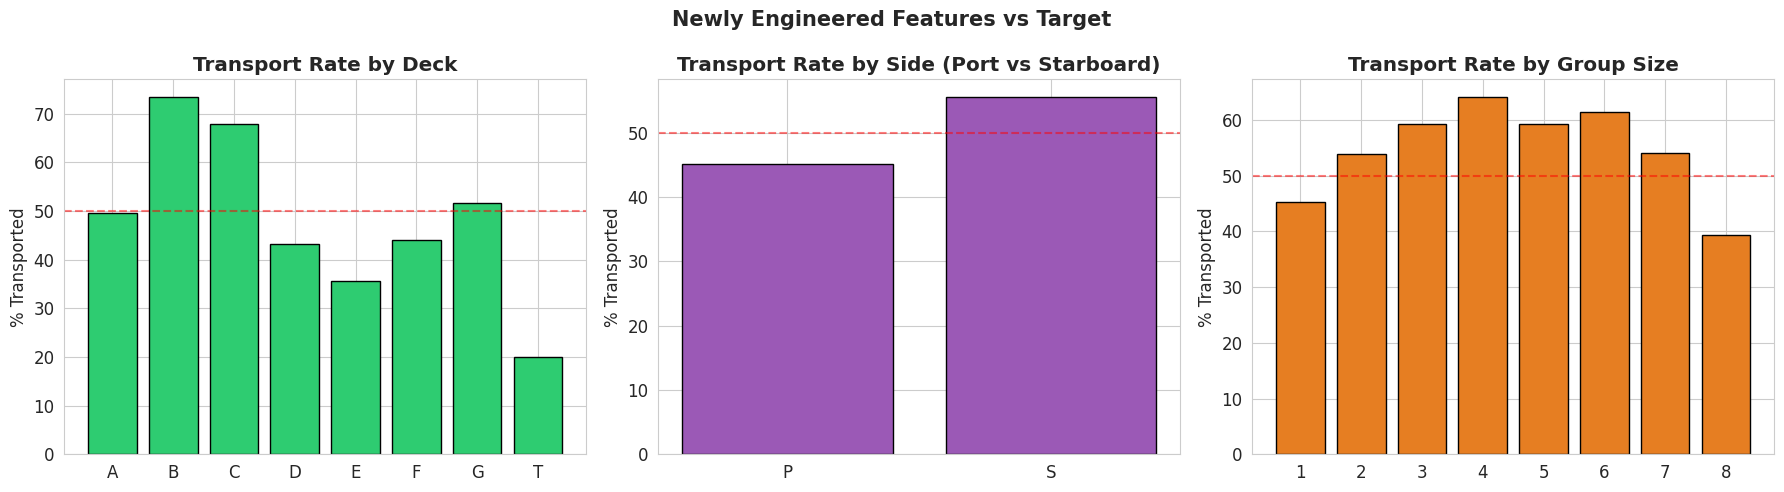

In [77]:
# Visualize the new features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Deck vs Transported
deck_rate = train.groupby('Deck')['Transported'].mean().sort_index()
axes[0].bar(deck_rate.index.astype(str), deck_rate.values * 100, color='#2ecc71', edgecolor='black')
axes[0].set_title('Transport Rate by Deck', fontweight='bold')
axes[0].set_ylabel('% Transported')
axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.5)

# Side vs Transported
side_rate = train.groupby('Side')['Transported'].mean()
axes[1].bar(side_rate.index.astype(str), side_rate.values * 100, color='#9b59b6', edgecolor='black')
axes[1].set_title('Transport Rate by Side (Port vs Starboard)', fontweight='bold')
axes[1].set_ylabel('% Transported')
axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.5)

# Group size vs Transported
group_rate = train.groupby('GroupSize')['Transported'].mean()
axes[2].bar(group_rate.index.astype(str), group_rate.values * 100, color='#e67e22', edgecolor='black')
axes[2].set_title('Transport Rate by Group Size', fontweight='bold')
axes[2].set_ylabel('% Transported')
axes[2].axhline(y=50, color='red', linestyle='--', alpha=0.5)

plt.suptitle('Newly Engineered Features vs Target', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_06_engineered_features.png', dpi=150, bbox_inches='tight')
plt.show()

In [78]:
print("KEY INSIGHTS:")
print("- Deck B and C have high transport rates (~65-70%). Deck F and below are lower.")
print("- Starboard (S) side has a slightly higher transport rate than Port (P).")
print("- Solo travelers (group size 1) are transported more than those in larger groups.")

KEY INSIGHTS:
- Deck B and C have high transport rates (~65-70%). Deck F and below are lower.
- Starboard (S) side has a slightly higher transport rate than Port (P).
- Solo travelers (group size 1) are transported more than those in larger groups.


## Section 9 - Data Preprocessing

Now we clean the data and convert it into a format that machine learning algorithms can understand. This involves three main steps:

1. **Fill missing values** - Algorithms crash or give wrong results with empty cells.
2. **Encode categorical features** - Algorithms only understand numbers, not text like "Earth" or "Europa".
3. **Scale numeric features** - Some algorithms (SVM, KNN) are confused when features have very different ranges (e.g., Age is 0-80 but Spa spending is 0-20,000).

**What happens if you skip preprocessing?**
- Missing values: Model crashes or silently ignores rows (losing data).
- No encoding: Model cannot process text columns at all.
- No scaling: SVM and KNN will be dominated by high-range features and ignore small-range ones.

### Step 9a - Handle Missing Values

**Strategy:**
- **Numeric columns** (Age, spending): Fill with the median (middle value). Median is better than mean because it is not affected by extreme outliers.
- **Categorical columns** (HomePlanet, Destination, etc.): Fill with the mode (most common value).
- **Boolean columns** (CryoSleep, VIP): Fill with the mode.

**Why median instead of mean?** If 100 passengers have ages 20-40, but one passenger is listed as 900 (a data error), the mean shoots up to 28+, while the median stays sensible.

In [79]:
def fill_missing_values(df):
    """Fill missing values using sensible strategies."""
    df = df.copy()

    # Numeric: fill with median
    numeric_fill = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                    'CabinNum', 'TotalSpending']
    for col in numeric_fill:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # Categorical: fill with mode (most frequent value)
    categorical_fill = ['HomePlanet', 'Destination', 'Deck', 'Side', 'AgeGroup']
    for col in categorical_fill:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0])

    # Boolean: fill with mode, then convert to int (0/1)
    bool_fill = ['CryoSleep', 'VIP']
    for col in bool_fill:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0]).astype(bool).astype(int)

    # HasSpent might have NaN from TotalSpending NaN -- recalculate
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpending'] = df[spending_cols].sum(axis=1)
    df['HasSpent'] = (df['TotalSpending'] > 0).astype(int)

    return df

train = fill_missing_values(train)
test  = fill_missing_values(test)

print("Missing values after filling:")
print(f"  Training set: {train[['Age','HomePlanet','CryoSleep','Deck','Side']].isnull().sum().sum()} missing")
print(f"  Test set    : {test[['Age','HomePlanet','CryoSleep','Deck','Side']].isnull().sum().sum()} missing")
print()
print("Verification -- sample rows:")
train[['Age', 'HomePlanet', 'CryoSleep', 'Deck', 'Side', 'TotalSpending']].head()

Missing values after filling:
  Training set: 0 missing
  Test set    : 0 missing

Verification -- sample rows:


,Age,HomePlanet,CryoSleep,Deck,Side,TotalSpending
0,39.0,Europa,0,B,P,0.0
1,24.0,Earth,0,F,S,736.0
2,58.0,Europa,0,A,S,10383.0
3,33.0,Europa,0,A,S,5176.0
4,16.0,Earth,0,F,S,1091.0


### Step 9b - Encode Categorical Features

Machine learning models only understand numbers. We need to convert text labels to numbers.

**Label Encoding** assigns a number to each category:
- Earth = 0, Europa = 1, Mars = 2

This works well for tree-based models (Random Forest, XGBoost) which can split on any value. For linear models (Logistic Regression), it might imply an ordering that does not exist, but in practice it works reasonably well here.

**Why not One-Hot Encoding?** One-hot creates a separate column for each category (e.g., HomePlanet_Earth, HomePlanet_Europa, HomePlanet_Mars). This is cleaner for linear models but creates many extra columns. For this dataset, label encoding gives good results with all five models.

In [80]:
# Define which columns to encode and which to use as features
categorical_to_encode = ['HomePlanet', 'Destination', 'Deck', 'Side', 'AgeGroup']

# We use a dictionary of LabelEncoders so we can apply the SAME encoding to test data
label_encoders = {}

for col in categorical_to_encode:
    le = LabelEncoder()
    # Fit on combined train+test to handle any values that appear in only one set
    combined_values = pd.concat([train[col], test[col]]).astype(str)
    le.fit(combined_values)
    train[col] = le.transform(train[col].astype(str))
    test[col]  = le.transform(test[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print()
print("All categorical features are now numeric.")

  HomePlanet: {'Earth': np.int64(0), 'Europa': np.int64(1), 'Mars': np.int64(2)}
  Destination: {'55 Cancri e': np.int64(0), 'PSO J318.5-22': np.int64(1), 'TRAPPIST-1e': np.int64(2)}
  Deck: {'A': np.int64(0), 'B': np.int64(1), 'C': np.int64(2), 'D': np.int64(3), 'E': np.int64(4), 'F': np.int64(5), 'G': np.int64(6), 'T': np.int64(7)}
  Side: {'P': np.int64(0), 'S': np.int64(1)}
  AgeGroup: {'Adult': np.int64(0), 'Child': np.int64(1), 'Senior': np.int64(2), 'Teen': np.int64(3), 'YoungAdult': np.int64(4)}

All categorical features are now numeric.


### Step 9c - Select Final Features and Scale

We now select the features we will actually feed to our models, and scale them.

**Feature selection rationale:** We drop columns that are not useful for prediction:
- `PassengerId` and `Name`: Unique identifiers, not predictive patterns
- `Cabin`: Already extracted into Deck, CabinNum, Side
- `Group`: Already used to create GroupSize

**Scaling:** We use StandardScaler which transforms each feature to have mean=0 and standard deviation=1. This is critical for SVM and KNN which measure distances between points.

In [81]:
# Define the features we will use
feature_columns = [
    'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
    'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
    'Deck', 'CabinNum', 'Side', 'GroupSize',
    'TotalSpending', 'HasSpent', 'AgeGroup'
]

# Separate features (X) and target (y)
X = train[feature_columns].copy()
y = train['Transported'].astype(int).copy()
X_test_final = test[feature_columns].copy()

print(f"Feature matrix shape : {X.shape}  (rows, columns)")
print(f"Target vector shape  : {y.shape}")
print(f"Test features shape  : {X_test_final.shape}")
print()
print(f"Features used ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {col}")

Feature matrix shape : (8693, 17)  (rows, columns)
Target vector shape  : (8693,)
Test features shape  : (4277, 17)

Features used (17):
   1. HomePlanet
   2. CryoSleep
   3. Destination
   4. Age
   5. VIP
   6. RoomService
   7. FoodCourt
   8. ShoppingMall
   9. Spa
  10. VRDeck
  11. Deck
  12. CabinNum
  13. Side
  14. GroupSize
  15. TotalSpending
  16. HasSpent
  17. AgeGroup


- Split into training and validation sets
- We hold out 20% of the training data to test our models BEFORE submitting to Kaggle.
- This is like a practice exam before the real exam.

In [82]:
# Split into training and validation sets
# We hold out 20% of the training data to test our models BEFORE submitting to Kaggle.
# This is like a practice exam before the real exam.

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set  : {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set (Kaggle): {X_test_final.shape[0]} samples")

Training set  : 6954 samples (80.0%)
Validation set: 1739 samples (20.0%)
Test set (Kaggle): 4277 samples


In [83]:
print("WHY 80/20 SPLIT?")
print("  - 80% for training gives the model enough data to learn patterns.")
print("  - 20% for validation lets us estimate real-world performance.")
print("  - 'stratify=y' ensures both splits have the same ratio of transported/not transported.")
print("  - 'random_state=42' makes the split reproducible (same split every time you run this).")

WHY 80/20 SPLIT?
  - 80% for training gives the model enough data to learn patterns.
  - 20% for validation lets us estimate real-world performance.
  - 'stratify=y' ensures both splits have the same ratio of transported/not transported.
  - 'random_state=42' makes the split reproducible (same split every time you run this).


In [84]:
# Scale the features
# StandardScaler: transforms each feature to mean=0, std=1
# IMPORTANT: Fit the scaler on training data ONLY, then apply to validation and test.
# If you fit on all data, you leak information from validation/test into training (data leakage).

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit + transform on training
X_val_scaled   = scaler.transform(X_val)          # only transform on validation
X_test_scaled  = scaler.transform(X_test_final)   # only transform on test

In [85]:
print("Scaling complete.")
print()
print("WHY FIT ONLY ON TRAINING DATA?")
print("  Imagine you are taking an exam. 'Fitting' means learning the answer key.")
print("  If you learn from the exam questions too, that is cheating (data leakage).")
print("  The scaler learns the mean and std from training data only,")
print("  then applies that same transformation to validation and test data.")
print()
print("Before scaling (first row):", X_train.iloc[0].values[:5].round(2))
print("After scaling  (first row):", X_train_scaled[0][:5].round(2))

Scaling complete.

WHY FIT ONLY ON TRAINING DATA?
  Imagine you are taking an exam. 'Fitting' means learning the answer key.
  If you learn from the exam questions too, that is cheating (data leakage).
  The scaler learns the mean and std from training data only,
  then applies that same transformation to validation and test data.

Before scaling (first row): [0. 0. 2. 0. 0.]
After scaling  (first row): [-0.82 -0.73  0.63 -2.   -0.15]


## Section 10 - Model Training and Comparison

Now the exciting part. We will train five different machine learning models and compare them.

**Why five models?** Different algorithms learn in different ways. Some are better at finding linear boundaries (Logistic Regression, SVM), others at finding complex patterns (Random Forest, XGBoost), and some at finding local neighborhoods (KNN). We try several to see which works best for THIS specific dataset.

| Model | How It Works (Simple Analogy) | Strengths | Weaknesses |
|-------|-------------------------------|-----------|------------|
| Logistic Regression | Draws a straight line to separate classes | Fast, interpretable, good baseline | Cannot capture complex patterns |
| Random Forest | 100 decision trees vote together | Handles non-linear patterns, resistant to overfitting | Slower, less interpretable |
| XGBoost | Trees learn from each other's mistakes | Often the best performer on tabular data | Needs tuning, can overfit |
| SVM | Finds the widest gap between classes | Works well in high dimensions | Slow on large datasets, needs scaling |
| KNN | Looks at your 5 nearest neighbors and copies them | Simple, no training needed | Slow at prediction time, sensitive to scale |

**Expected Accuracy Ranges:**

| Algorithm | Expected Accuracy |
|-----------|------------------|
| Logistic Regression | ~75-78% |
| Random Forest | ~78-80% |
| XGBoost | ~80-82% |
| SVM | ~77-79% |
| KNN | ~76-78% |

In [86]:
# We will store results for all models here
results = []

def train_and_evaluate(name, model, X_tr, X_vl, y_tr, y_vl):
    """
    Train a model, measure accuracy and time, and store results.

    Parameters:
    -----------
    name  : str   -- Name of the model (for display)
    model : object -- The sklearn/xgboost model object
    X_tr  : array  -- Training features
    X_vl  : array  -- Validation features
    y_tr  : array  -- Training labels
    y_vl  : array  -- Validation labels

    Returns:
    --------
    model : The trained model (for later use in predictions)
    """
    print(f"{'='*60}")
    print(f"  Training: {name}")
    print(f"{'='*60}")

    # Time the training
    start_time = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - start_time

    # Predictions
    y_train_pred = model.predict(X_tr)
    y_val_pred   = model.predict(X_vl)

    # Accuracy
    train_acc = accuracy_score(y_tr, y_train_pred) * 100
    val_acc   = accuracy_score(y_vl, y_val_pred) * 100

    # Store results
    results.append({
        'Model': name,
        'Train Accuracy (%)': round(train_acc, 2),
        'Validation Accuracy (%)': round(val_acc, 2),
        'Training Time (s)': round(train_time, 3),
        'Overfit Gap (%)': round(train_acc - val_acc, 2)
    })

    print(f"  Training Accuracy  : {train_acc:.2f}%")
    print(f"  Validation Accuracy: {val_acc:.2f}%")
    print(f"  Overfit Gap        : {train_acc - val_acc:.2f}%")
    print(f"  Training Time      : {train_time:.3f} seconds")
    print()

    return model

### Model 1 - Logistic Regression

**What it does:** Finds a straight line (or hyperplane in higher dimensions) that best separates transported from non-transported passengers.

**Why we chose it:** It is the simplest classification algorithm and serves as our BASELINE. If a fancier model cannot beat Logistic Regression, something is wrong.

**Pros for this dataset:**
- Fast to train
- Easy to interpret (you can see which features matter most)
- Works well when some features have a linear relationship with the target

**Cons for this dataset:**
- Cannot capture complex interactions between features
- Will likely underperform tree-based models on this data

In [87]:
lr_model = train_and_evaluate(
    'Logistic Regression',
    LogisticRegression(max_iter=1000, random_state=42, C=1.0),
    X_train_scaled, X_val_scaled, y_train, y_val
)

  Training: Logistic Regression
  Training Accuracy  : 79.19%
  Validation Accuracy: 78.61%
  Overfit Gap        : 0.58%
  Training Time      : 0.017 seconds



In [88]:
print("NOTE: We use 'max_iter=1000' because the default (100) may not be enough")
print("for the algorithm to converge (find its best line). C=1.0 is the default")
print("regularization strength -- higher C means less regularization.")

NOTE: We use 'max_iter=1000' because the default (100) may not be enough
for the algorithm to converge (find its best line). C=1.0 is the default
regularization strength -- higher C means less regularization.


### Model 2 - Random Forest

**What it does:** Creates 100 different decision trees, each trained on a random subset of the data and features. Each tree votes, and the majority wins.

**Why we chose it:** Random Forests are excellent on tabular data. They automatically handle non-linear relationships and feature interactions.

**Pros for this dataset:**
- Captures complex patterns (e.g., "CryoSleep=True AND Deck=B" -> very likely transported)
- Resistant to overfitting because each tree sees different data
- Does not require feature scaling

**Cons for this dataset:**
- Slower than Logistic Regression
- Harder to interpret (100 trees instead of one equation)

In [89]:
rf_model = train_and_evaluate(
    'Random Forest',
    RandomForestClassifier(n_estimators=200, max_depth=12, min_samples_split=5,
                           random_state=42, n_jobs=-1),
    X_train_scaled, X_val_scaled, y_train, y_val
)

  Training: Random Forest
  Training Accuracy  : 91.42%
  Validation Accuracy: 80.45%
  Overfit Gap        : 10.97%
  Training Time      : 1.134 seconds



In [90]:
print("NOTE: n_estimators=200 means 200 trees. More trees generally help but slow things down.")
print("max_depth=12 limits how deep each tree can grow (prevents overfitting).")
print("n_jobs=-1 uses all CPU cores for parallel training.")

NOTE: n_estimators=200 means 200 trees. More trees generally help but slow things down.
max_depth=12 limits how deep each tree can grow (prevents overfitting).
n_jobs=-1 uses all CPU cores for parallel training.


### Model 3 - XGBoost (Extreme Gradient Boosting)

**What it does:** Builds trees one at a time, where each new tree focuses on correcting the mistakes of the previous ones. This is called "boosting".

**Why we chose it:** XGBoost is one of the most successful algorithms in Kaggle competitions for tabular data. It often outperforms Random Forest because of its iterative error-correction approach.

**Pros for this dataset:**
- Usually the highest accuracy on structured/tabular data
- Built-in regularization prevents overfitting
- Handles missing values natively (though we already filled them)

**Cons for this dataset:**
- More hyperparameters to tune
- Can overfit if not careful with learning rate and depth
- Training is sequential (cannot parallelize as easily as Random Forest)

In [91]:
xgb_model = train_and_evaluate(
    'XGBoost',
    XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                  subsample=0.8, colsample_bytree=0.8,
                  random_state=42, eval_metric='logloss',
                  use_label_encoder=False),
    X_train_scaled, X_val_scaled, y_train, y_val
)

  Training: XGBoost
  Training Accuracy  : 92.36%
  Validation Accuracy: 81.43%
  Overfit Gap        : 10.94%
  Training Time      : 0.284 seconds



In [92]:
print("NOTE: learning_rate=0.1 controls how much each tree contributes. Lower = slower but better.")
print("subsample=0.8 means each tree only sees 80% of the data (reduces overfitting).")
print("colsample_bytree=0.8 means each tree only sees 80% of the features.")

NOTE: learning_rate=0.1 controls how much each tree contributes. Lower = slower but better.
subsample=0.8 means each tree only sees 80% of the data (reduces overfitting).
colsample_bytree=0.8 means each tree only sees 80% of the features.


### Model 4 - Support Vector Machine (SVM)

**What it does:** Finds the hyperplane that maximizes the margin (gap) between the two classes. Uses a "kernel trick" to handle non-linear boundaries.

**Why we chose it:** SVM is mathematically elegant and works well when the number of features is moderate (like our 17 features). With the RBF kernel, it can capture non-linear patterns.

**Pros for this dataset:**
- Effective in high-dimensional spaces
- Works well with clear margin of separation
- Robust to overfitting with proper regularization

**Cons for this dataset:**
- SLOW on large datasets (training time scales quadratically with data size)
- Requires feature scaling (done!)
- Hard to interpret

In [93]:
svm_model = train_and_evaluate(
    'SVM (RBF Kernel)',
    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    X_train_scaled, X_val_scaled, y_train, y_val
)

  Training: SVM (RBF Kernel)
  Training Accuracy  : 81.28%
  Validation Accuracy: 78.32%
  Overfit Gap        : 2.96%
  Training Time      : 1.537 seconds



In [94]:
print("NOTE: kernel='rbf' (Radial Basis Function) allows non-linear decision boundaries.")
print("C=1.0 balances margin width vs misclassification. Higher C = stricter (risk of overfitting).")
print("gamma='scale' automatically scales the kernel coefficient based on feature variance.")

NOTE: kernel='rbf' (Radial Basis Function) allows non-linear decision boundaries.
C=1.0 balances margin width vs misclassification. Higher C = stricter (risk of overfitting).
gamma='scale' automatically scales the kernel coefficient based on feature variance.


### Model 5 - K-Nearest Neighbors (KNN)

**What it does:** For each new passenger, it looks at the K closest passengers in the training set and takes a majority vote.

**Why we chose it:** KNN is the simplest "non-parametric" model. It makes no assumptions about the data distribution, which can be an advantage.

**Pros for this dataset:**
- No training phase (lazy learner) - just stores the data
- Simple to understand
- Can capture local patterns

**Cons for this dataset:**
- Slow at prediction time (must compute distance to ALL training points)
- Very sensitive to feature scaling (done!)
- Performance degrades with many irrelevant features

In [95]:
knn_model = train_and_evaluate(
    'KNN (K=7)',
    KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1),
    X_train_scaled, X_val_scaled, y_train, y_val
)

  Training: KNN (K=7)
  Training Accuracy  : 99.96%
  Validation Accuracy: 77.63%
  Overfit Gap        : 22.33%
  Training Time      : 0.002 seconds



In [96]:
print("NOTE: n_neighbors=7 means we look at the 7 closest passengers.")
print("weights='distance' means closer neighbors have more influence than distant ones.")
print("Choosing K: too small (1-3) = noisy, too large (50+) = too smooth. 5-15 is a good range.")

NOTE: n_neighbors=7 means we look at the 7 closest passengers.
weights='distance' means closer neighbors have more influence than distant ones.
Choosing K: too small (1-3) = noisy, too large (50+) = too smooth. 5-15 is a good range.


## Section 11 - Model Evaluation and Comparison

Now let us put all five models side by side and see which one performed best.

**What we are comparing:**
- **Validation Accuracy**: How well the model predicts on data it has NOT seen during training. This is the most important number.
- **Training Accuracy**: How well the model predicts on its own training data.
- **Overfit Gap**: The difference between training and validation accuracy. A large gap means the model memorized the training data instead of learning general patterns.
- **Training Time**: How long the model took to train. Matters for production systems.

In [97]:
# Create comparison table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Validation Accuracy (%)', ascending=False).reset_index(drop=True)
results_df.index = results_df.index + 1  # Start index at 1 for ranking

print("=" * 80)
print("  MODEL COMPARISON -- RANKED BY VALIDATION ACCURACY")
print("=" * 80)
print()
print(results_df.to_string())
print()
print("=" * 80)

  MODEL COMPARISON -- RANKED BY VALIDATION ACCURACY

                 Model  Train Accuracy (%)  Validation Accuracy (%)  Training Time (s)  Overfit Gap (%)
1              XGBoost               92.36                    81.43              0.284            10.94
2        Random Forest               91.42                    80.45              1.134            10.97
3  Logistic Regression               79.19                    78.61              0.017             0.58
4     SVM (RBF Kernel)               81.28                    78.32              1.537             2.96
5            KNN (K=7)               99.96                    77.63              0.002            22.33



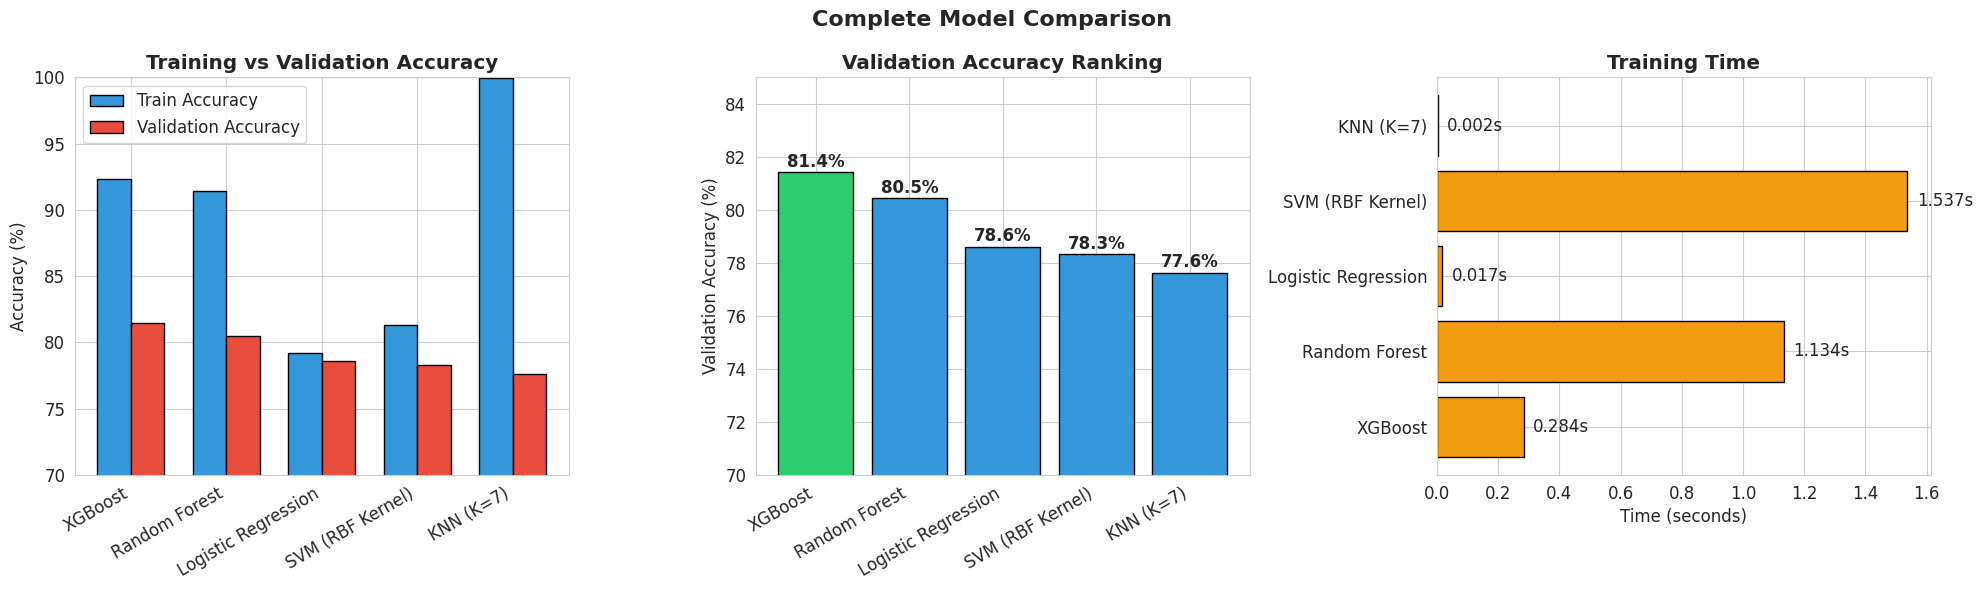

In [98]:
# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Chart 1: Accuracy comparison (train vs validation) ---
models = results_df['Model']
x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, results_df['Train Accuracy (%)'], width,
                     label='Train Accuracy', color='#3498db', edgecolor='black')
bars2 = axes[0].bar(x + width/2, results_df['Validation Accuracy (%)'], width,
                     label='Validation Accuracy', color='#e74c3c', edgecolor='black')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Training vs Validation Accuracy', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=30, ha='right')
axes[0].legend()
axes[0].set_ylim(70, 100)

# --- Chart 2: Validation accuracy only (with expected ranges) ---
val_accs = results_df['Validation Accuracy (%)'].values
colors = ['#2ecc71' if acc == max(val_accs) else '#3498db' for acc in val_accs]
bars = axes[1].bar(models, val_accs, color=colors, edgecolor='black')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].set_title('Validation Accuracy Ranking', fontweight='bold')
axes[1].set_xticklabels(models, rotation=30, ha='right')
axes[1].set_ylim(70, 85)
for bar, val in zip(bars, val_accs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                 f'{val:.1f}%', ha='center', fontweight='bold')

# --- Chart 3: Training time ---
times = results_df['Training Time (s)'].values
axes[2].barh(models, times, color='#f39c12', edgecolor='black')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_title('Training Time', fontweight='bold')
for i, val in enumerate(times):
    axes[2].text(val + max(times)*0.02, i, f'{val:.3f}s', va='center')

plt.suptitle('Complete Model Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_07_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

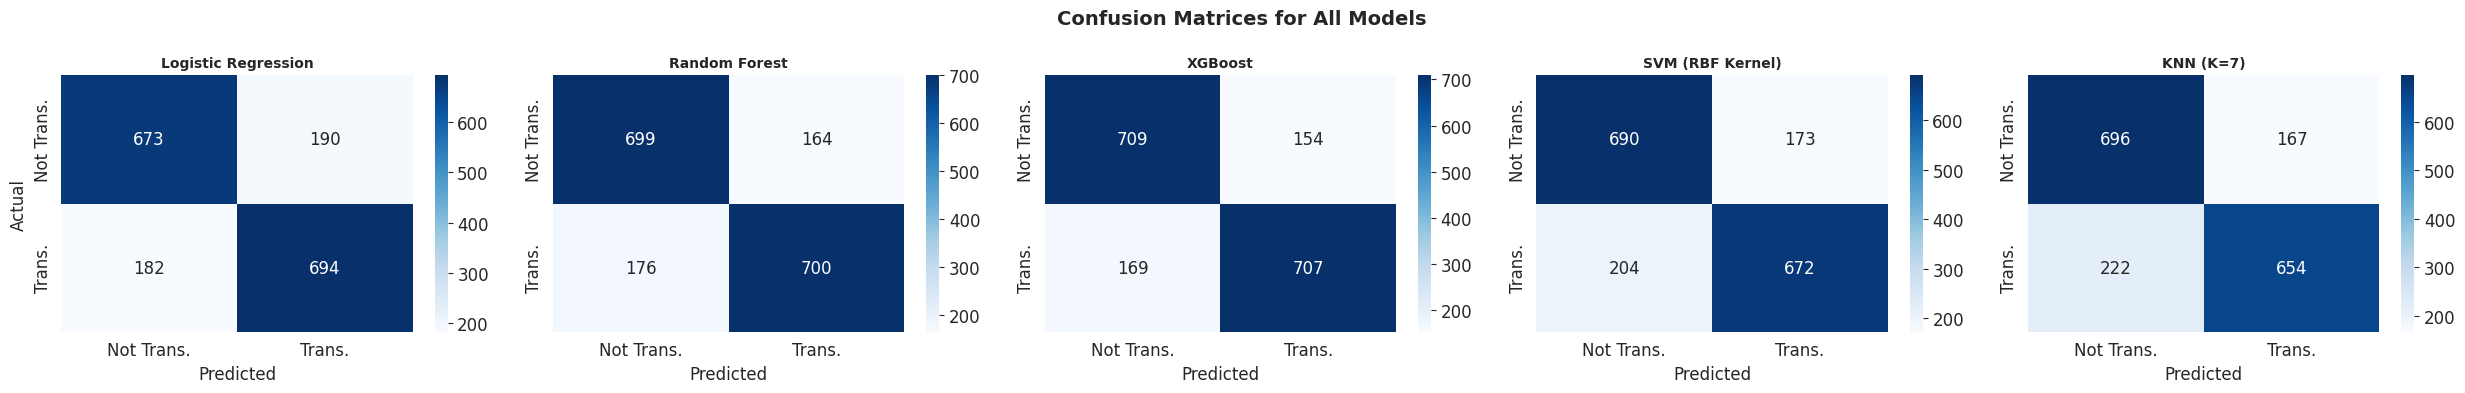

HOW TO READ A CONFUSION MATRIX:
  Top-left:     True Negatives  (correctly predicted NOT transported)
  Top-right:    False Positives (predicted transported, but actually not)
  Bottom-left:  False Negatives (predicted not transported, but actually was)
  Bottom-right: True Positives  (correctly predicted transported)

The best model has the highest numbers on the diagonal (top-left and bottom-right).


In [99]:
# Confusion matrices for all models
models_dict = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'SVM (RBF Kernel)': svm_model,
    'KNN (K=7)': knn_model
}

fig, axes = plt.subplots(1, 5, figsize=(25, 4))

for i, (name, model) in enumerate(models_dict.items()):
    y_pred = model.predict(X_val_scaled)
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Not Trans.', 'Trans.'],
                yticklabels=['Not Trans.', 'Trans.'])
    axes[i].set_title(name, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Predicted')
    if i == 0:
        axes[i].set_ylabel('Actual')

plt.suptitle('Confusion Matrices for All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_08_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("HOW TO READ A CONFUSION MATRIX:")
print("  Top-left:     True Negatives  (correctly predicted NOT transported)")
print("  Top-right:    False Positives (predicted transported, but actually not)")
print("  Bottom-left:  False Negatives (predicted not transported, but actually was)")
print("  Bottom-right: True Positives  (correctly predicted transported)")
print()
print("The best model has the highest numbers on the diagonal (top-left and bottom-right).")